In [1]:
import os
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

DATASET_PATH = '/kaggle/input/urdu-emotion-dataset'

# 1. Metadata Preparation

In [2]:
metadata = {
    'file': [],
    'emotion': [],
    'duration': [],
    'sampling_rate': []
}

for emotion_folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, emotion_folder)
    if os.path.isdir(folder_path):
        for audio_file in os.listdir(folder_path):
            if audio_file.endswith('.wav'):
                file_path = os.path.join(folder_path, audio_file)
                try:
                    y, sr = librosa.load(file_path, sr=None)
                    duration = librosa.get_duration(y=y, sr=sr)
                    metadata['file'].append(file_path)
                    metadata['emotion'].append(emotion_folder)
                    metadata['duration'].append(duration)
                    metadata['sampling_rate'].append(sr)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

metadata_df = pd.DataFrame(metadata)

In [3]:
metadata_df.head()

file emotion  duration  \
0  /kaggle/input/urdu-emotion-dataset/Angry/SM4_F...   Angry  2.000000   
1  /kaggle/input/urdu-emotion-dataset/Angry/SM4_F...   Angry  3.003537   
2  /kaggle/input/urdu-emotion-dataset/Angry/SM4_F...   Angry  2.000000   
3  /kaggle/input/urdu-emotion-dataset/Angry/SM4_F...   Angry  3.003537   
4  /kaggle/input/urdu-emotion-dataset/Angry/SM1_F...   Angry  3.003537   

   sampling_rate  
0          44100  
1          44100  
2          44100  
3          44100  
4          44100

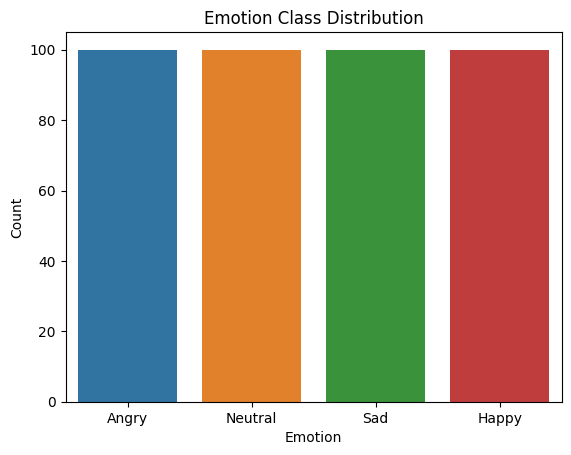

In [4]:
sns.countplot(metadata_df, x='emotion')
plt.title('Emotion Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [5]:
metadata_df['duration'].describe()

count    400.000000
mean       2.496740
std        0.507404
min        0.992109
25%        2.000000
50%        2.000000
75%        3.003537
max        3.003537
Name: duration, dtype: float64

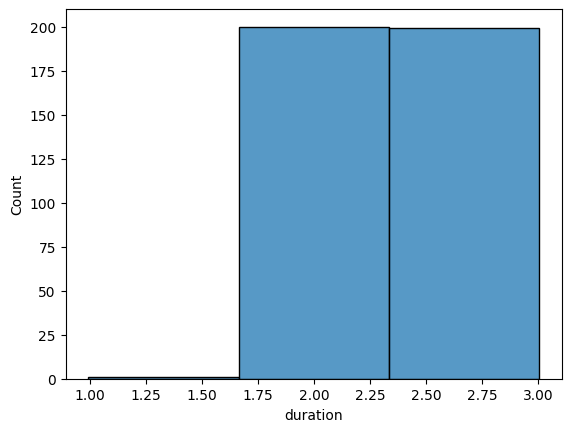

In [6]:
sns.histplot(metadata_df, x='duration', bins=3)
plt.show()

In [7]:
metadata_df['emotion'].unique()

array(['Angry', 'Neutral', 'Sad', 'Happy'], dtype=object)

# 2. Sample Audios from Each Category with Waveforms

Sample Audio for Angry:


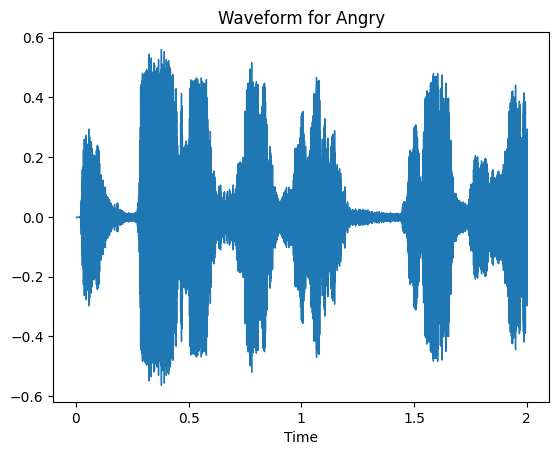


Sample Audio for Neutral:


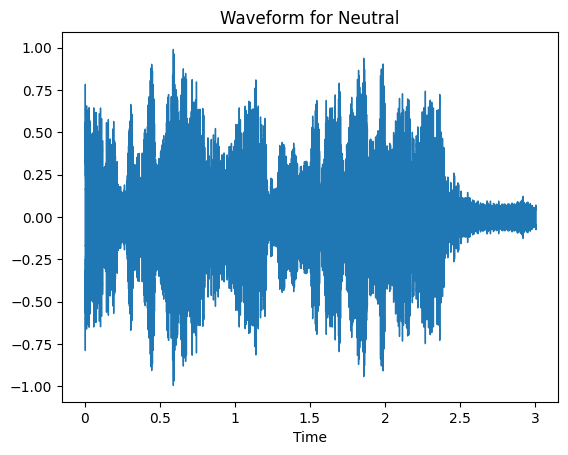


Sample Audio for Sad:


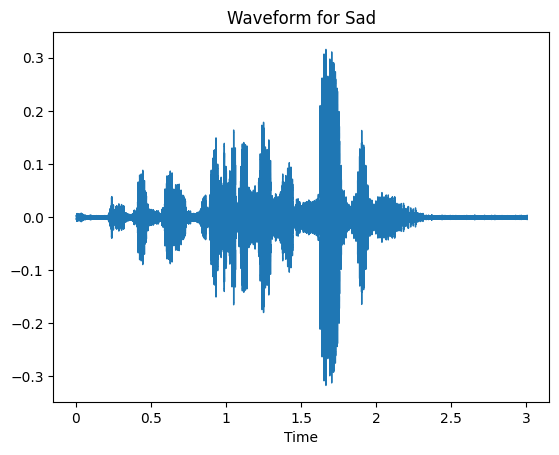


Sample Audio for Happy:


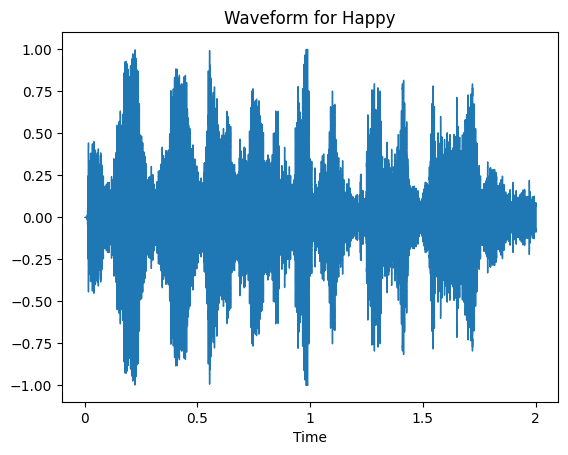

In [8]:
for emotion in metadata_df['emotion'].unique():
    file_path = metadata_df[metadata_df['emotion'] == emotion]['file'].iloc[0]
    y, sr = librosa.load(file_path, sr=None)
    plt.figure()
    librosa.display.waveshow(y, sr=sr)
    print(f"Sample Audio for {emotion}:")
    display(Audio(file_path))
    plt.title(f"Waveform for {emotion}")
    plt.show()
    print()

# 3. Sample Audios from Each Category with Spectograms

Sample Audio for Angry:


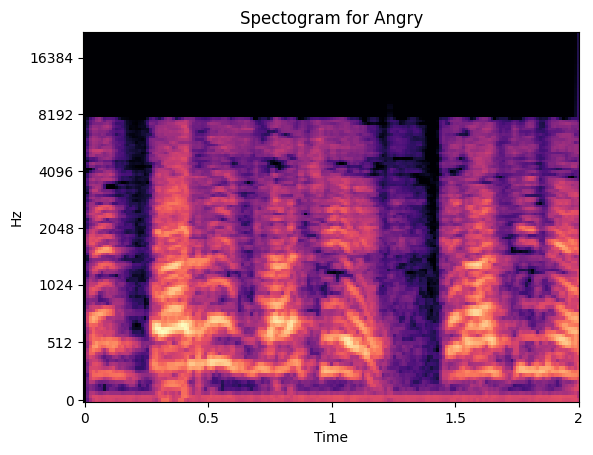


Sample Audio for Neutral:


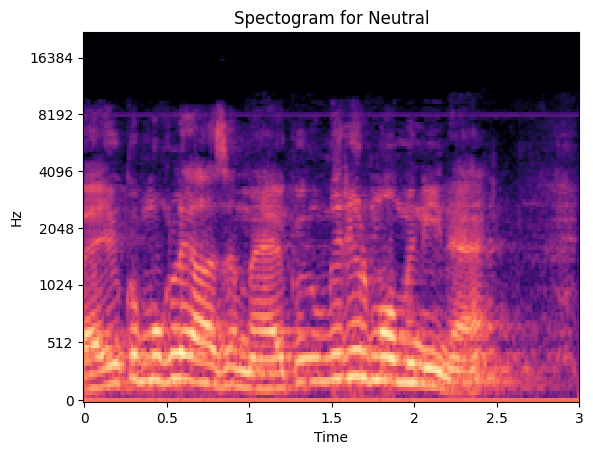


Sample Audio for Sad:


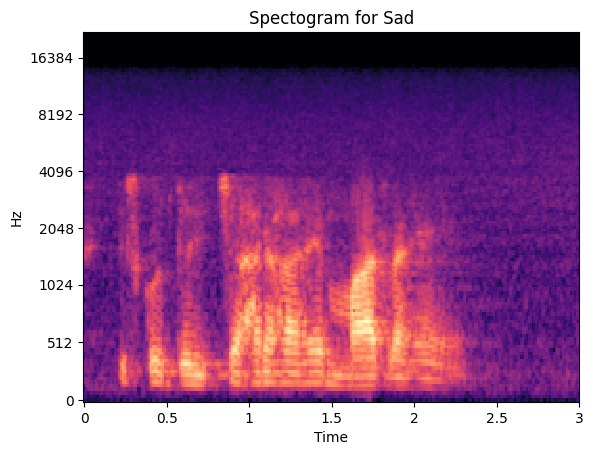


Sample Audio for Happy:


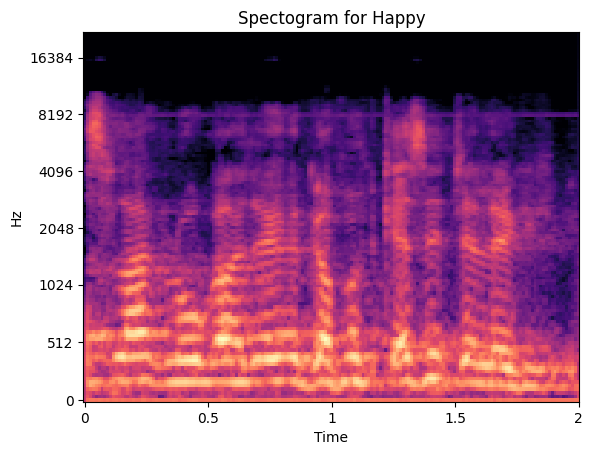

In [9]:
for emotion in metadata_df['emotion'].unique():
    file_path = metadata_df[metadata_df['emotion'] == emotion]['file'].iloc[0]
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure()

    print(f"Sample Audio for {emotion}:")
    display(Audio(file_path))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.title(f"Spectogram for {emotion}")
    plt.show()
    print()

In [10]:
def plot_histogram_with_kde(df, feature, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, hue="emotion", kde=True, bins=20, alpha=0.5)
    plt.title(f"Histogram with KDE for {title} by Emotion")
    plt.xlabel(title)
    plt.ylabel("Frequency")
    plt.show()

def plot_feature_vs_categorical_target(df, feature, target_column="emotion"):
    plt.figure(figsize=(8, 6))
    sns.stripplot(data=df, x=feature, y=target_column, jitter=True, alpha=0.7)
    plt.title(f"Strip Plot: {feature} vs {target_column}")
    plt.xlabel(feature)
    plt.ylabel(target_column)
    plt.show()

def plot_boxplot(df, feature, title):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x="emotion", y=feature)
    plt.title(f"Box Plot of {feature} by Emotion")
    plt.xlabel("Emotion")
    plt.ylabel(title)
    plt.show()
    
def scatter_plot_feature_by_sample(df, feature, target_column="emotion"):
    plt.figure(figsize=(10, 6))
    
    for emotion in df[target_column].unique():
        subset = df[df[target_column] == emotion]
        plt.scatter(subset.index, subset[feature], label=emotion, alpha=0.7)

    plt.title(f"Scatter Plot: {feature} by Sample Index")
    plt.xlabel("Sample Index")
    plt.ylabel(feature)
    plt.legend(title=target_column)
    plt.grid(True)
    plt.show()
    
def plot_correlation_heatmap(df, target_column="emotion", annot=True):
    label_encoder = LabelEncoder()
    df_copy = df.copy()
    df_copy[target_column + "_numeric"] = label_encoder.fit_transform(df_copy[target_column])
    df_copy.drop(target_column, axis=1, inplace=True)
    correlation_matrix = df_copy.corr() 
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=annot, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap with Encoded Target")
    plt.show()


# 4. Feature Extraction

## 1. Zero Crossing Rate

In [11]:
zcr_list = []
for _, row in metadata_df.iterrows():
    data, sample_rate = librosa.load(row["file"])
    zcr = librosa.feature.zero_crossing_rate(y=data).mean()  # Direct scalar value
    zcr_list.append([zcr, row["emotion"]])  

zcr_df = pd.DataFrame(zcr_list, columns=["ZCR", "emotion"])
zcr_df.head()

ZCR emotion
0  0.091320   Angry
1  0.070887   Angry
2  0.061798   Angry
3  0.057061   Angry
4  0.049745   Angry

In [12]:
zcr_df.describe()

ZCR
count  400.000000
mean     0.073508
std      0.041513
min      0.021793
25%      0.046774
50%      0.063218
75%      0.087899
max      0.315099

### Histogram for Zero Crossing Rate by Emotion

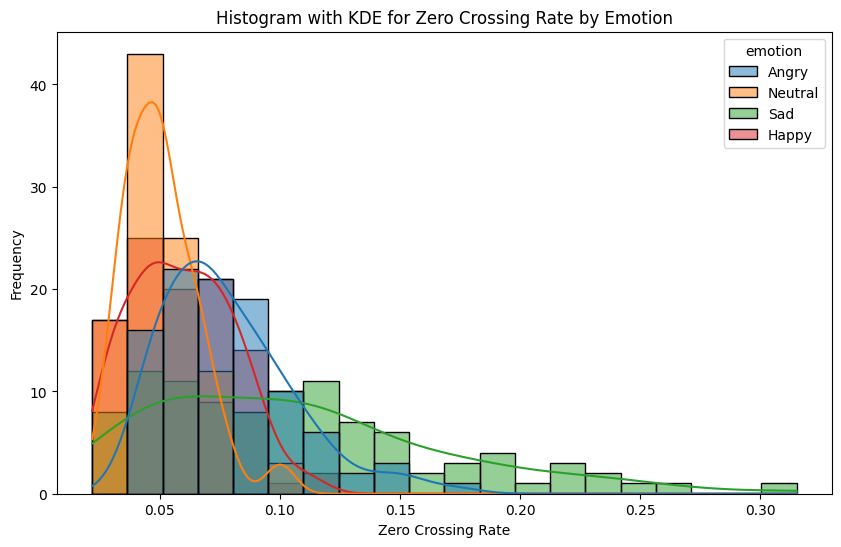

In [13]:
plot_histogram_with_kde(zcr_df, 'ZCR', 'Zero Crossing Rate')

### Strip Plot for ZCR vs Emotion

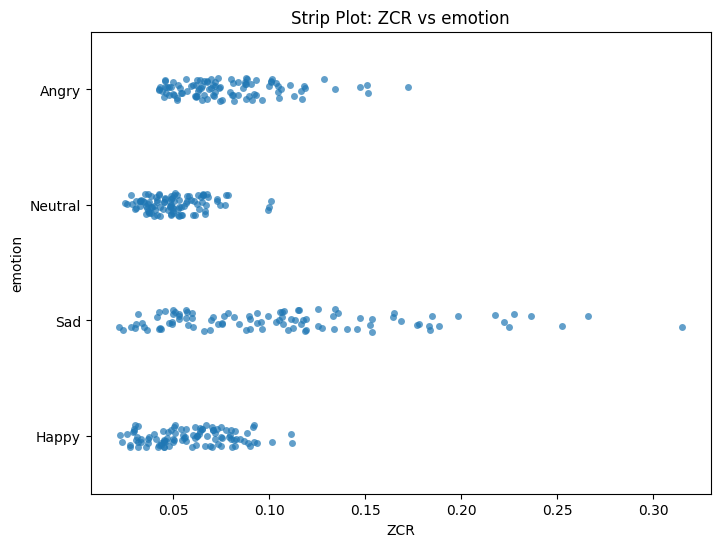

In [14]:
plot_feature_vs_categorical_target(zcr_df, 'ZCR', target_column="emotion")

### Scatter Plot for ZCR

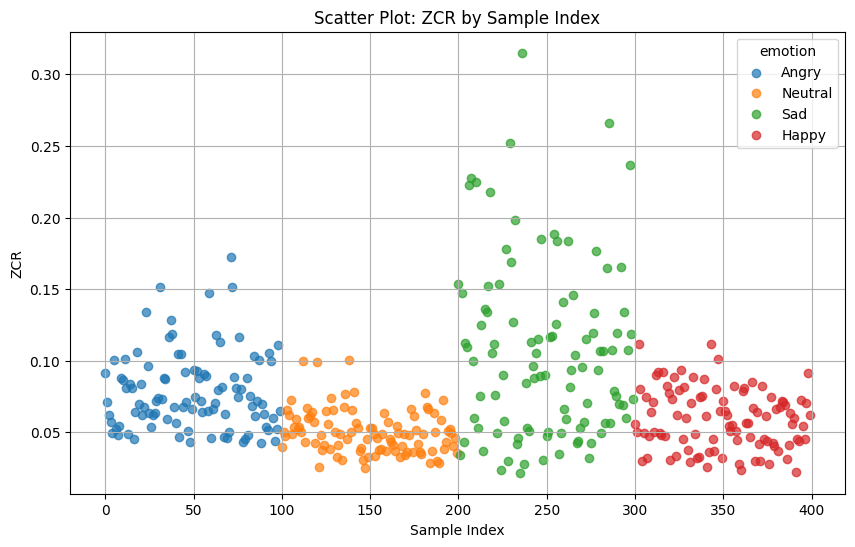

In [15]:
scatter_plot_feature_by_sample(zcr_df, 'ZCR')

### Boxplot for ZCR by Emotion

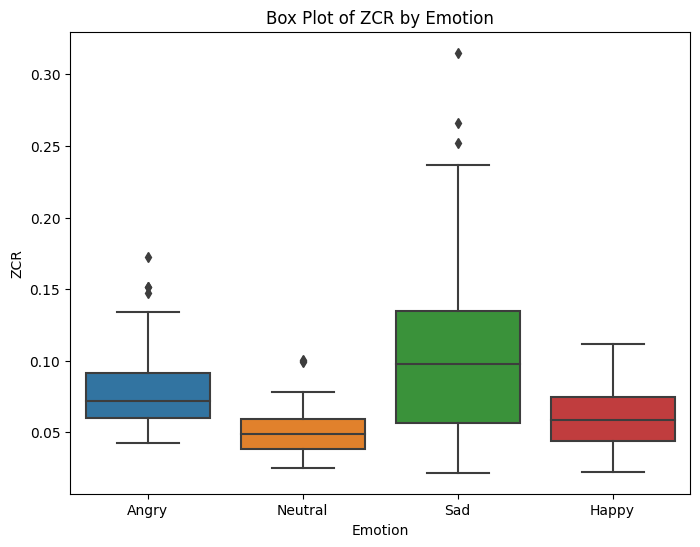

In [16]:
plot_boxplot(zcr_df, 'ZCR', 'ZCR')

## 2. MFCCs (Mel-Frequency Cepstral Cofficients)

In [17]:
mfcc_list = []
for _, row in metadata_df.iterrows():
    data, sample_rate = librosa.load(row["file"])
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate).mean(axis=1)
    mfcc_list.append(list(mfcc) + [row["emotion"]])

mfcc_columns = [f"MFCC_{i}" for i in range(20)] + ["emotion"]
mfcc_df = pd.DataFrame(mfcc_list, columns=mfcc_columns)
mfcc_df.head()

MFCC_0      MFCC_1     MFCC_2     MFCC_3     MFCC_4     MFCC_5  \
0 -188.470764  109.967346 -42.413364  33.335987 -30.330341   9.138726   
1 -248.053299  103.685173 -18.847075  38.517456 -19.335085   5.011625   
2 -256.788513  115.254929 -12.114532  27.983555 -28.089148   7.765107   
3 -238.685577  127.544350  -9.724557  22.484619 -18.023149  10.864928   
4 -176.139725  114.823135 -34.065102  11.556516   7.050622 -17.943701   

      MFCC_6    MFCC_7     MFCC_8     MFCC_9  ...   MFCC_11    MFCC_12  \
0 -39.706383  7.189990 -11.838692   4.591185  ... -8.882810   9.618686   
1 -40.926052 -7.197815 -13.969601   3.907028  ...  0.516283   8.276394   
2 -30.097071 -2.629414 -21.728060  -3.063583  ...  8.850088  13.469765   
3 -31.297428 -1.836660 -13.216015  -3.445664  ...  3.217000  16.078093   
4 -21.713697  8.152995 -15.158186  11.061510  ...  7.536058  -1.889625   

    MFCC_13    MFCC_14   MFCC_15    MFCC_16   MFCC_17   MFCC_18   MFCC_19  \
0 -4.727997   5.204946 -7.278394   3.542253 -0.991589  9.028372  0.945431   
1 -4.405193  17.803362  0.540712   1.924802 -3.880643  1.379398 -6.539081   
2 -8.409696   9.990783  7.513363   4.914454 -5.543636  0.180445 -4.628216   
3 -0.474811   9.814095  1.754892   1.672746  1.593567  6.943057 -6.474025   
4  5.492126  -5.522218  5.892736 -10.753709 -0.589195 -4.470378 -9.205222   

   emotion  
0    Angry  
1    Angry  
2    Angry  
3    Angry  
4    Angry  

[5 rows x 21 columns]

In [18]:
mfcc_df.describe()

MFCC_0      MFCC_1      MFCC_2      MFCC_3      MFCC_4      MFCC_5  \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean  -248.687683  121.585861  -10.895857   25.616541   -7.123994   -4.604899   
std     75.398888   25.408897   18.438913   14.289445   12.564219    9.619614   
min   -461.152161   27.267485  -53.358280   -9.662998  -52.796829  -32.418285   
25%   -301.413490  107.222952  -24.425714   14.833090  -13.964533  -12.213152   
50%   -234.939537  122.825203   -9.407207   26.011205   -4.969620   -4.585061   
75%   -188.550243  138.084366    2.742871   35.842436    1.816558    3.469668   
max    -89.843712  202.491409   47.705673   66.316795   19.117962   19.305918   

           MFCC_6      MFCC_7      MFCC_8      MFCC_9     MFCC_10     MFCC_11  \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean   -14.659729   -3.243345  -15.175831   -0.195078   -4.622059   -0.037566   
std      8.967015    8.187319   10.057170    7.487464    8.083058    6.457974   
min    -40.926052  -23.855680  -36.588348  -17.812677  -22.137197  -20.103346   
25%    -19.890226   -9.454738  -22.098489   -5.258409  -10.679492   -3.850957   
50%    -14.774812   -2.297186  -16.284048    0.005199   -5.511018    0.361032   
75%     -8.736359    3.160710   -9.151008    4.906970   -0.067979    4.065891   
max      6.803137   16.831184   12.707534   20.595749   16.078211   14.030724   

          MFCC_12     MFCC_13     MFCC_14     MFCC_15     MFCC_16     MFCC_17  \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean    -4.854403   -1.229617   -2.879522   -0.163827   -4.674177   -0.839536   
std      8.063086    5.098719    7.038570    4.698863    4.985514    4.329793   
min    -22.258768  -13.682552  -16.845345  -14.708689  -14.054208  -12.325232   
25%    -10.576735   -5.064531   -7.308225   -3.604794   -8.181533   -3.821628   
50%     -5.911090   -1.209135   -3.850758    0.107520   -5.654429   -0.559551   
75%     -1.450823    2.234968    0.106107    3.118052   -1.880539    2.328988   
max     21.408651   15.261943   18.019342   12.427334   18.387041    9.891826   

          MFCC_18     MFCC_19  
count  400.000000  400.000000  
mean    -1.950580   -1.520512  
std      5.211228    4.305164  
min    -14.428976  -12.541510  
25%     -5.899337   -4.638729  
50%     -2.493173   -2.087800  
75%      1.361299    0.257565  
max     15.179958   14.047431

In [19]:
data, sample_rate = librosa.load(row["file"])
mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
mfcc.shape

(13, 130)

### Histogram for MFCC 0 by Emotion

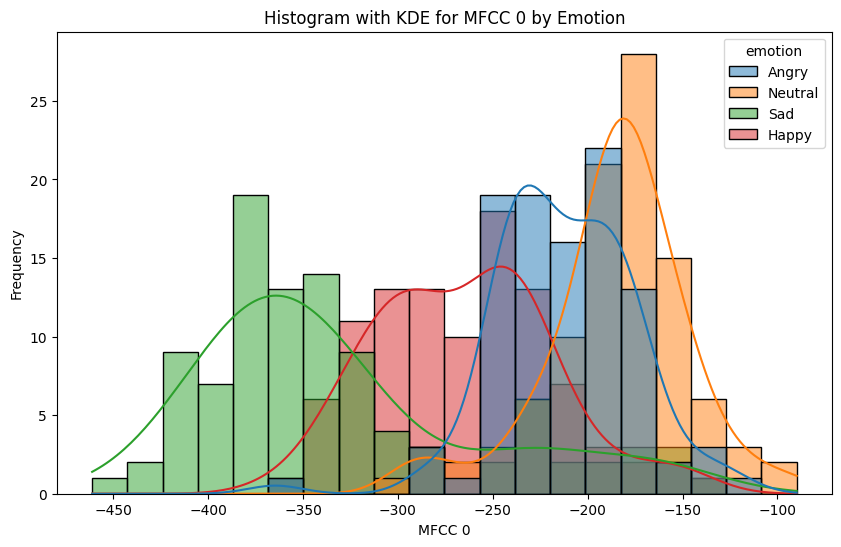

In [20]:
plot_histogram_with_kde(mfcc_df, 'MFCC_0', 'MFCC 0')

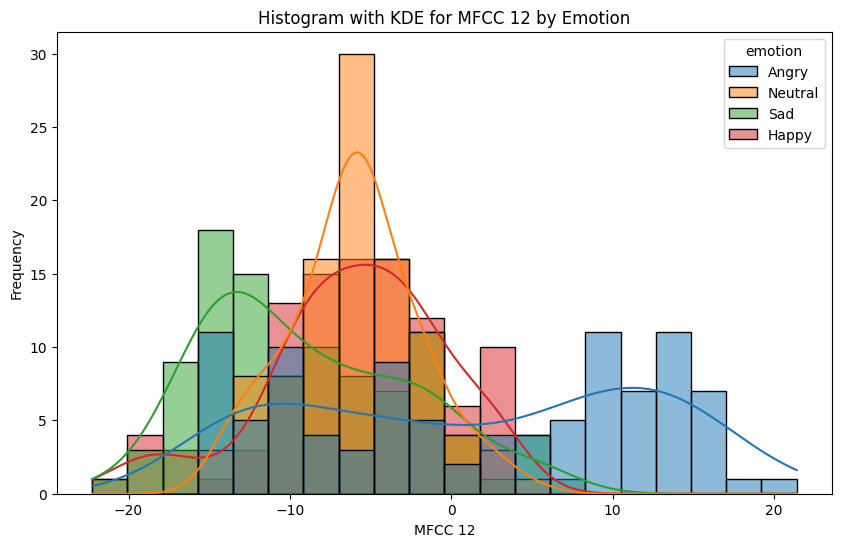

In [21]:
plot_histogram_with_kde(mfcc_df, 'MFCC_12', 'MFCC 12')

### Strip Plot for MFCC_0 vs Emotion

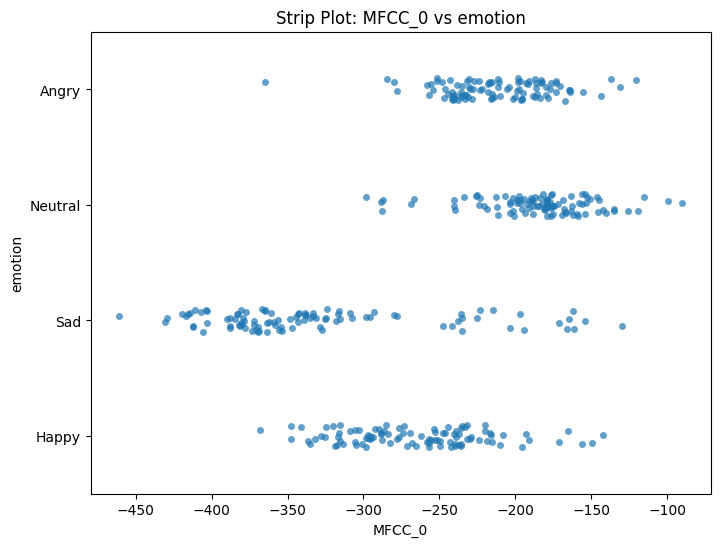

In [22]:
plot_feature_vs_categorical_target(mfcc_df, 'MFCC_0', target_column="emotion")

### Scatterplot for MFCC_0

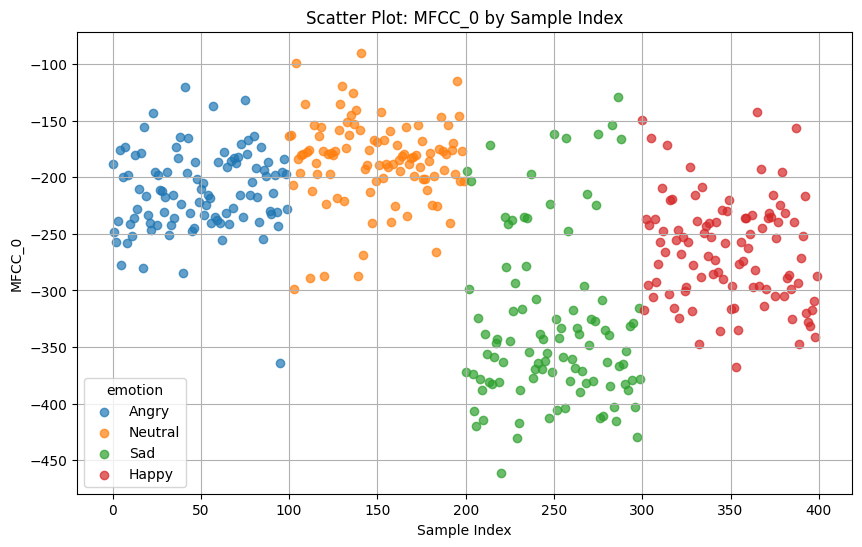

In [23]:
scatter_plot_feature_by_sample(mfcc_df, 'MFCC_0')

### Boxplot for MFCC_0 by Emotion

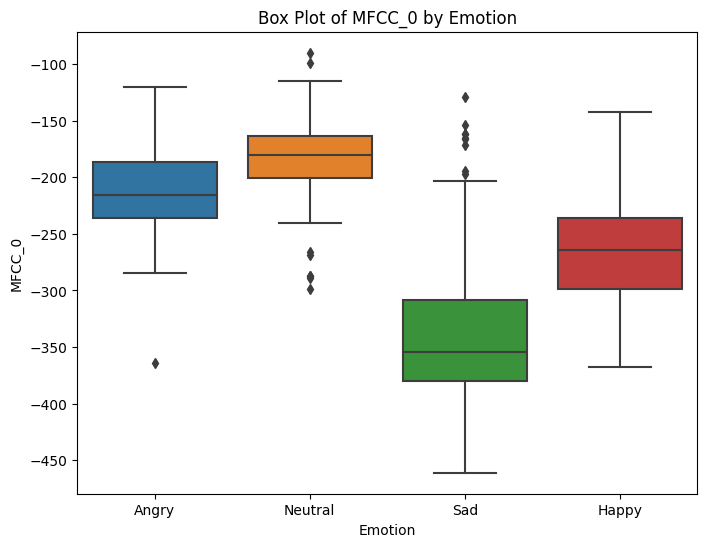

In [24]:
plot_boxplot(mfcc_df, 'MFCC_0', 'MFCC_0')

### Correlation Heatmap with encoded Emotion

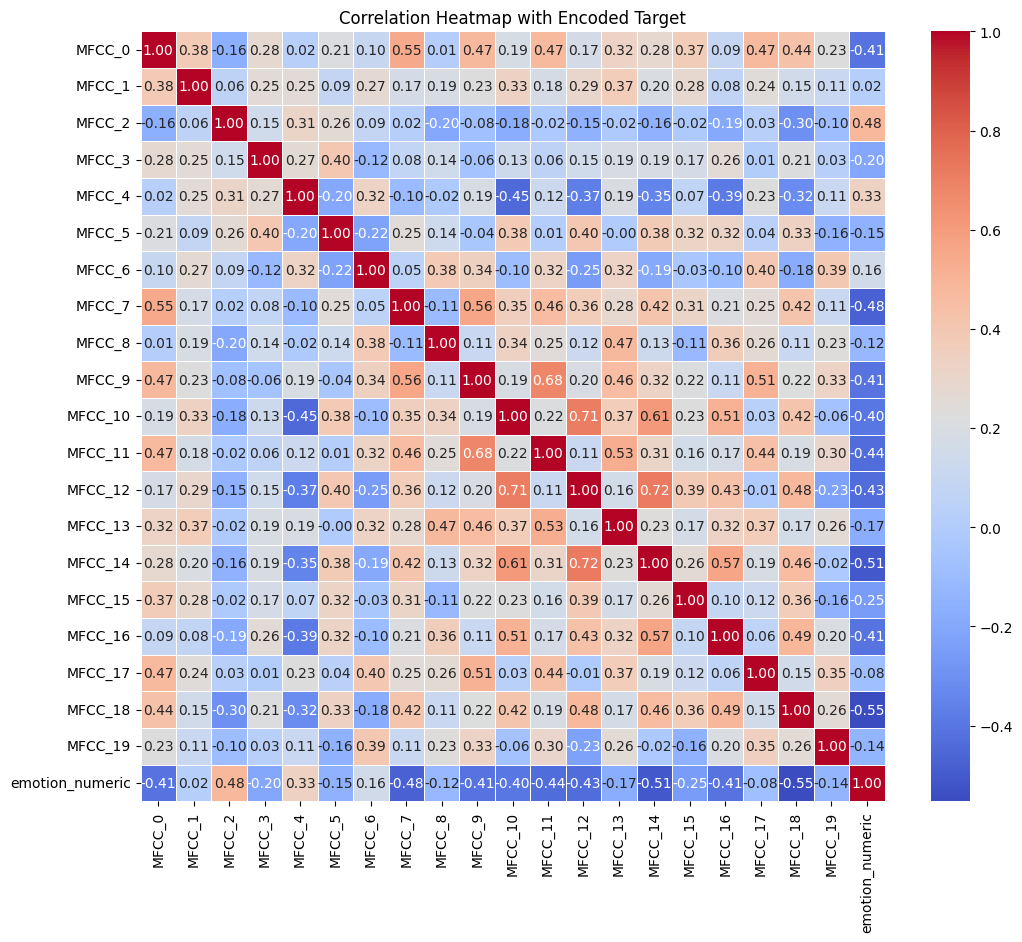

In [25]:
plot_correlation_heatmap(mfcc_df, target_column="emotion")

## 3. Chroma Features

In [26]:
chroma_list = []
for _, row in metadata_df.iterrows():
    data, sample_rate = librosa.load(row["file"])
    stft = np.abs(librosa.stft(data))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate).mean(axis=1)
    chroma_list.append(list(chroma) + [row["emotion"]])

chroma_columns = [f"Chroma_{i}" for i in range(12)] + ["emotion"]
chroma_df = pd.DataFrame(chroma_list, columns=chroma_columns)

chroma_df.head()

Chroma_0  Chroma_1  Chroma_2  Chroma_3  Chroma_4  Chroma_5  Chroma_6  \
0  0.535120  0.511413  0.468239  0.533743  0.606599  0.609614  0.491789   
1  0.655852  0.527285  0.451812  0.473533  0.424539  0.293453  0.306274   
2  0.675012  0.395649  0.298670  0.323802  0.378529  0.413010  0.364681   
3  0.378475  0.334971  0.343220  0.499382  0.488361  0.352248  0.360904   
4  0.616579  0.654416  0.639745  0.581414  0.430141  0.383965  0.375615   

   Chroma_7  Chroma_8  Chroma_9  Chroma_10  Chroma_11 emotion  
0  0.438342  0.485886  0.492630   0.440898   0.522234   Angry  
1  0.330277  0.331038  0.406119   0.449119   0.581985   Angry  
2  0.286827  0.315547  0.441678   0.590957   0.773464   Angry  
3  0.386586  0.531828  0.692188   0.651474   0.490581   Angry  
4  0.471560  0.481194  0.438975   0.506700   0.510406   Angry

In [27]:
chroma_df.describe()

Chroma_0    Chroma_1    Chroma_2    Chroma_3    Chroma_4    Chroma_5  \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean     0.560345    0.568682    0.569922    0.571618    0.562389    0.555133   
std      0.099677    0.105341    0.114179    0.109164    0.096828    0.105624   
min      0.301149    0.276155    0.212427    0.219722    0.228034    0.261918   
25%      0.496369    0.500577    0.494900    0.502881    0.506231    0.489553   
50%      0.562164    0.572215    0.577377    0.578123    0.566168    0.558833   
75%      0.625946    0.637996    0.650170    0.651076    0.626149    0.629089   
max      0.826896    0.875209    0.850344    0.835970    0.859958    0.807566   

         Chroma_6    Chroma_7    Chroma_8    Chroma_9   Chroma_10   Chroma_11  
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000  
mean     0.545726    0.540330    0.548562    0.559971    0.558140    0.555411  
std      0.111491    0.116217    0.118488    0.110486    0.101731    0.098304  
min      0.240208    0.190775    0.160320    0.201710    0.256275    0.289016  
25%      0.472151    0.465729    0.463044    0.487770    0.489708    0.492312  
50%      0.557116    0.554339    0.561524    0.565472    0.559621    0.549761  
75%      0.620306    0.623365    0.629054    0.635787    0.621500    0.620415  
max      0.811423    0.847367    0.820673    0.835968    0.857725    0.864115

### Histogram for Chroma_0 by Emotion

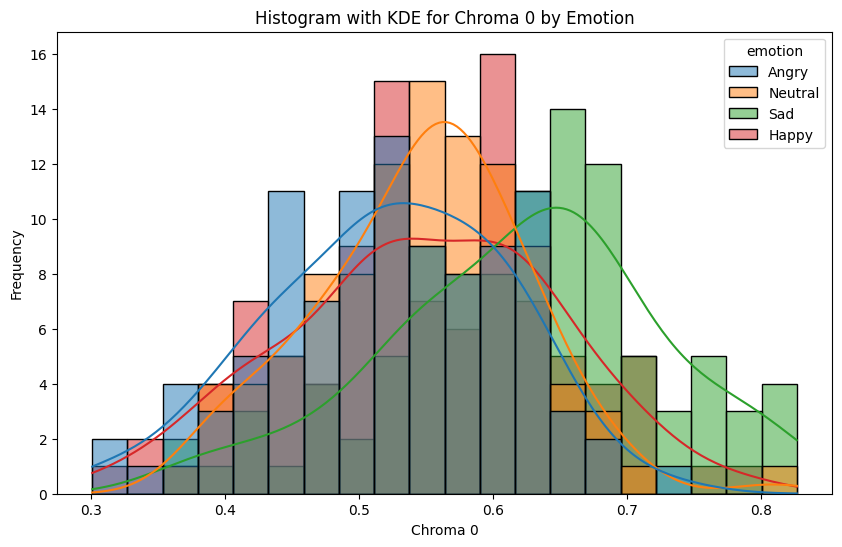

In [28]:
plot_histogram_with_kde(chroma_df, 'Chroma_0', 'Chroma 0')

### Strip Plot for Chroma_0 vs Emotion

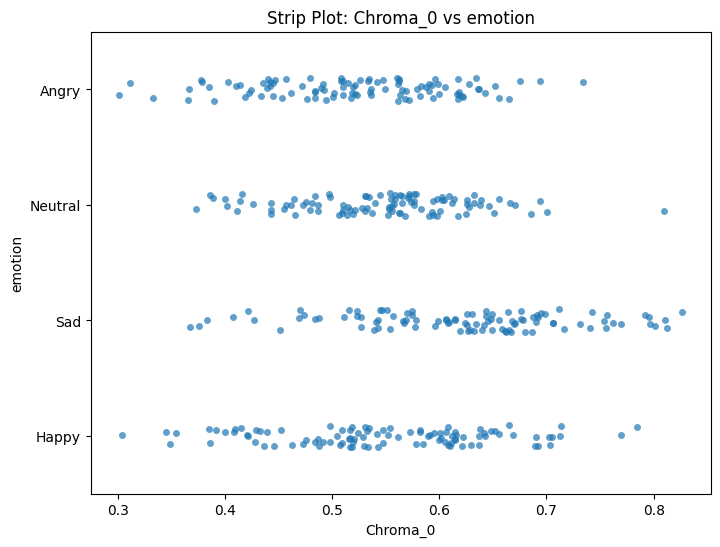

In [29]:
plot_feature_vs_categorical_target(chroma_df, 'Chroma_0', target_column="emotion")

### Scatterplot for Chroma_0

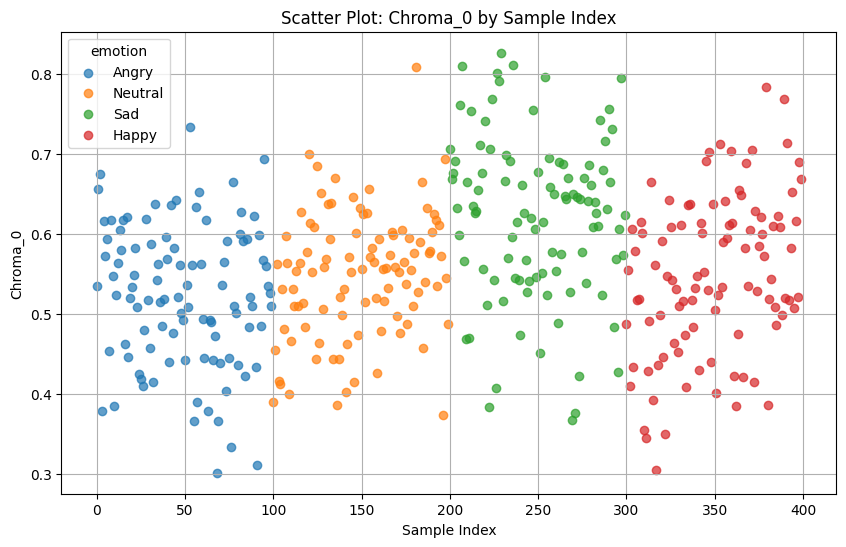

In [30]:
scatter_plot_feature_by_sample(chroma_df, 'Chroma_0')

### Boxplot for Chroma_0 by Emotion

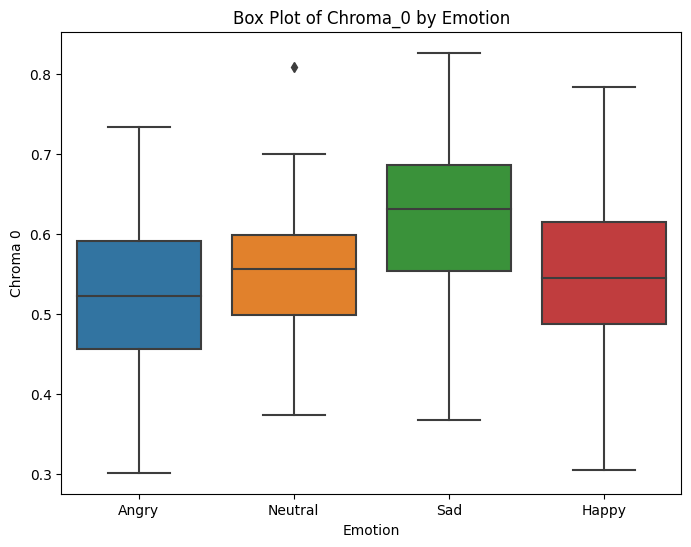

In [31]:
plot_boxplot(chroma_df, 'Chroma_0', 'Chroma 0')

### Correlation Heatmap with Encoded Emotion

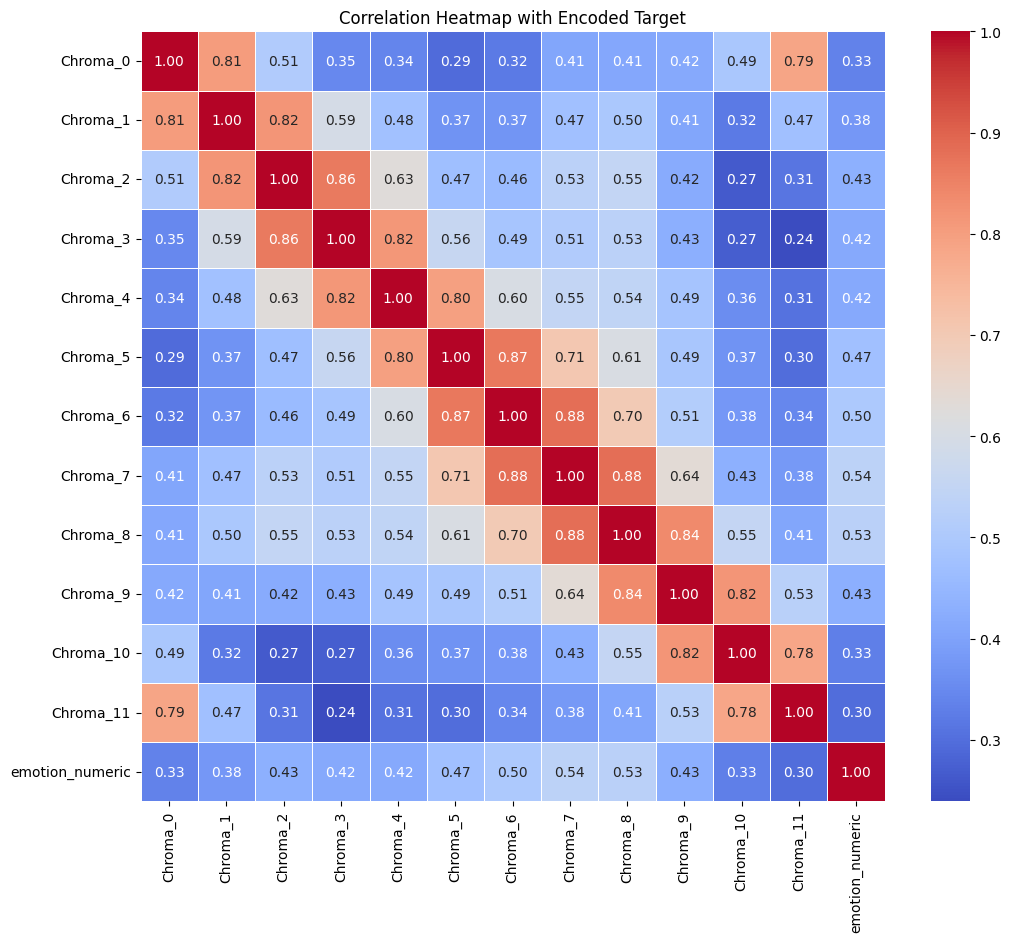

In [32]:
plot_correlation_heatmap(chroma_df, target_column="emotion")

## 4. Root Mean Square Energy

In [33]:
rms_list = []
for _, row in metadata_df.iterrows():
    data, sample_rate = librosa.load(row["file"])
    rms = librosa.feature.rms(y=data).mean()
    rms_list.append([rms, row["emotion"]])

rms_df = pd.DataFrame(rms_list, columns=["RMS", "emotion"])
rms_df.head()

RMS emotion
0  0.116387   Angry
1  0.087585   Angry
2  0.091757   Angry
3  0.109497   Angry
4  0.106876   Angry

In [34]:
rms_df.describe()

RMS
count  400.000000
mean     0.097318
std      0.064731
min      0.005586
25%      0.046091
50%      0.092192
75%      0.135859
max      0.368037

### Histogram for RMS by Emotion

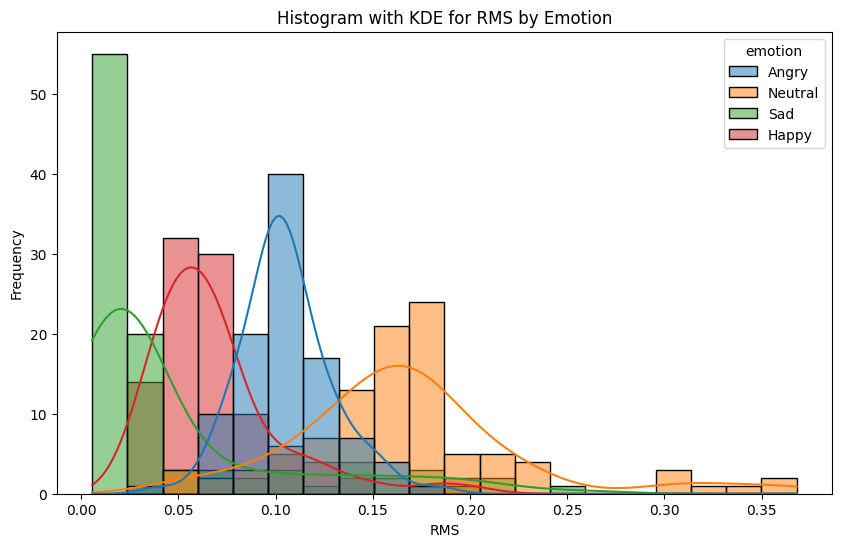

In [35]:
plot_histogram_with_kde(rms_df, 'RMS', 'RMS')

### Strip Plot for RMS vs Emotion

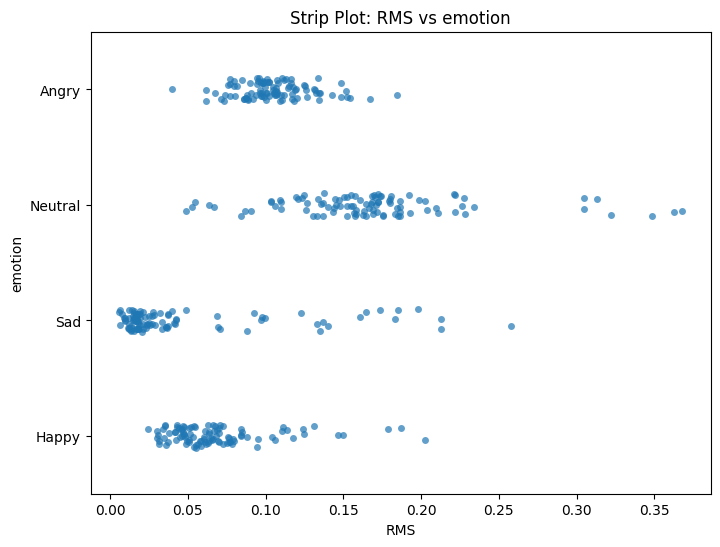

In [36]:
plot_feature_vs_categorical_target(rms_df, 'RMS', target_column="emotion")

### Scatterplot for RMS

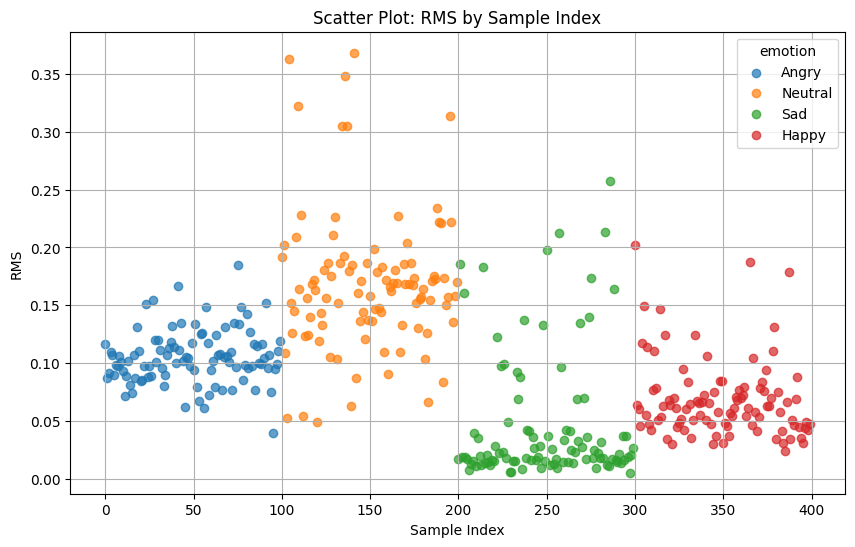

In [37]:
scatter_plot_feature_by_sample(rms_df, 'RMS')

### Boxplot of RMS by Emotion

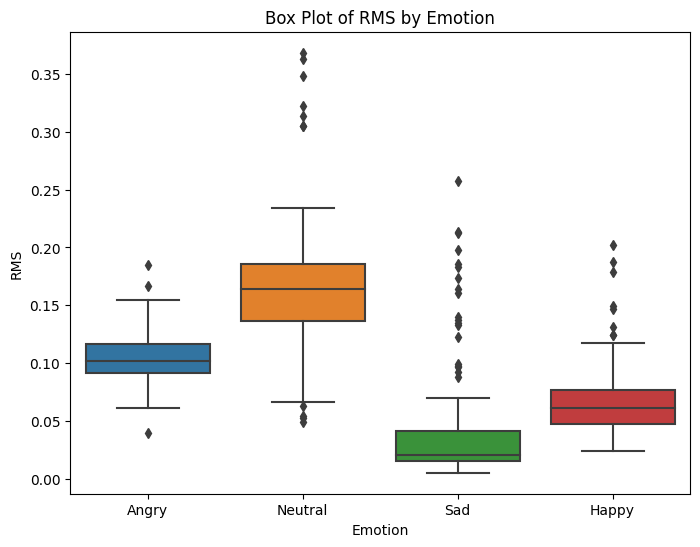

In [38]:
plot_boxplot(rms_df, 'RMS', 'RMS')

## 5. Mel Spectogram

In [39]:
mel_list = []
for _, row in metadata_df.iterrows():
    data, sample_rate = librosa.load(row["file"])
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rate).mean()
    mel_list.append([mel, row["emotion"]])

mel_df = pd.DataFrame(mel_list, columns=["Mel", "emotion"])
mel_df.head()

Mel emotion
0  4.487679   Angry
1  2.635538   Angry
2  2.837139   Angry
3  4.187739   Angry
4  2.462297   Angry

In [40]:
mel_df.describe()

Mel
count  400.000000
mean     4.105656
std      5.469861
min      0.014574
25%      0.626419
50%      2.232755
75%      5.393948
max     35.905140

### Histgoram for Mel by Emotion

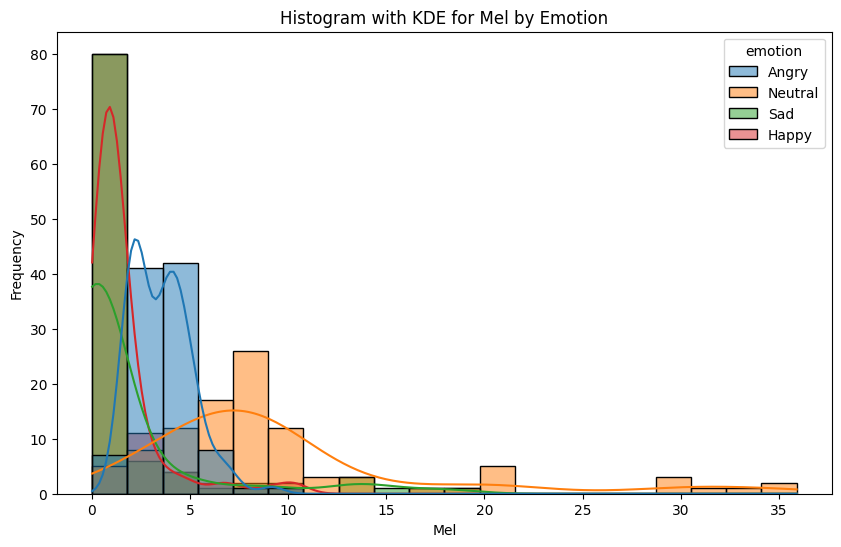

In [41]:
plot_histogram_with_kde(mel_df, 'Mel', 'Mel')

### Strip Plot for Mel vs Emotion

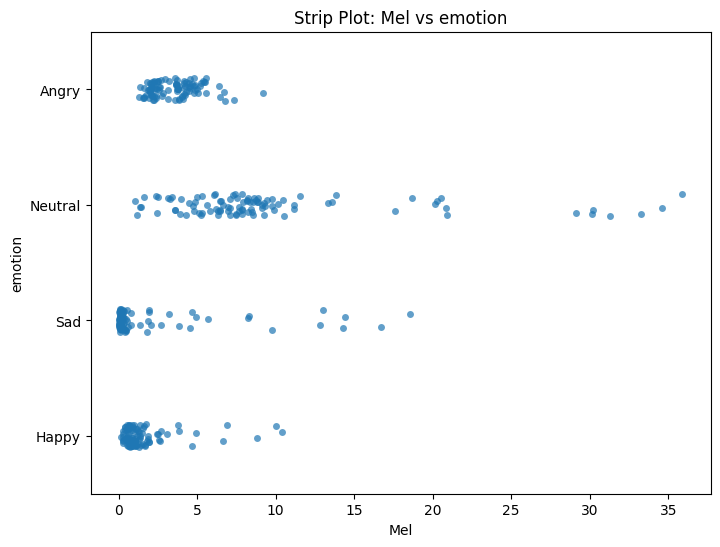

In [42]:
plot_feature_vs_categorical_target(mel_df, 'Mel', target_column="emotion")

### Scatterplot for Mel Spectrogram

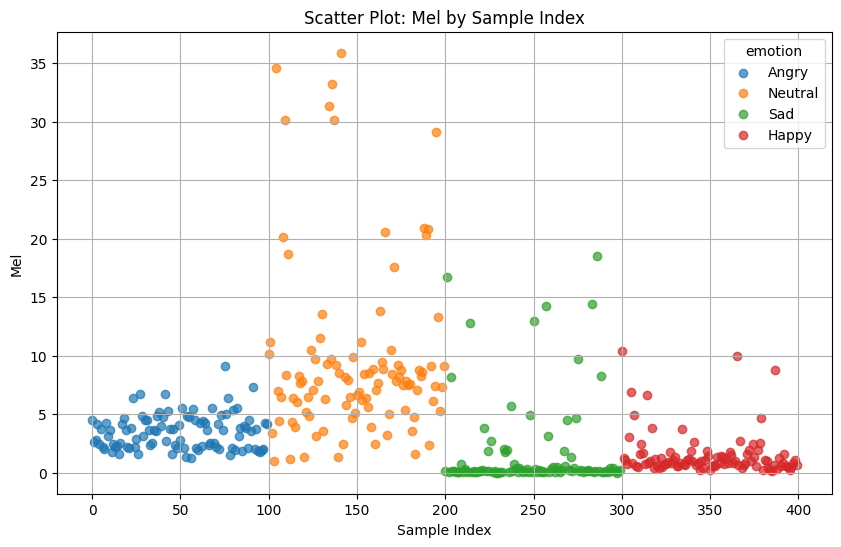

In [43]:
scatter_plot_feature_by_sample(mel_df, 'Mel')

### Boxplot for Mel by Emotion

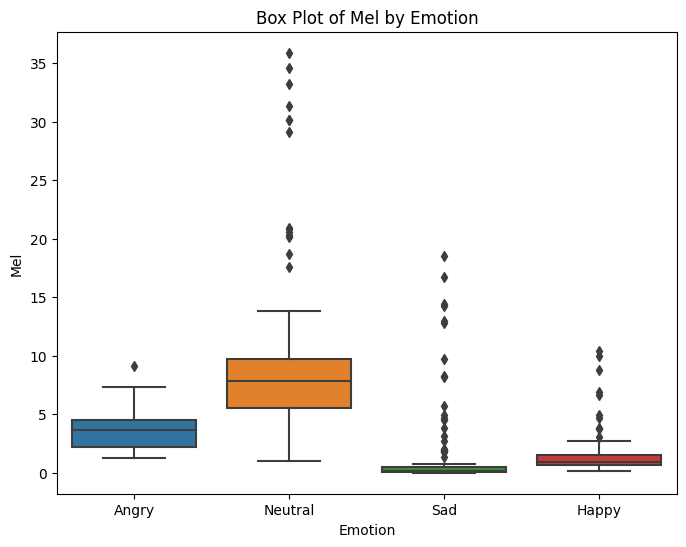

In [44]:
plot_boxplot(mel_df, 'Mel', 'Mel')

## 6. Spectral Centroid

In [45]:
spectral_centroid_list = []
for _, row in metadata_df.iterrows():
    data, sample_rate = librosa.load(row["file"])
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sample_rate).mean()
    spectral_centroid_list.append([spectral_centroid, row["emotion"]])

spectral_centroid_df = pd.DataFrame(spectral_centroid_list, columns=["Spectral Centroid", "emotion"])
spectral_centroid_df.head()

Spectral Centroid emotion
0        1912.396437   Angry
1        1738.408594   Angry
2        1575.015891   Angry
3        1396.520759   Angry
4        1715.942236   Angry

In [46]:
spectral_centroid_df.describe()

Spectral Centroid
count         400.000000
mean         1651.494692
std           493.511194
min           794.196610
25%          1334.524628
50%          1549.807665
75%          1853.680559
max          4088.091253

### Histgoram for Spectral Centroid by Emotion

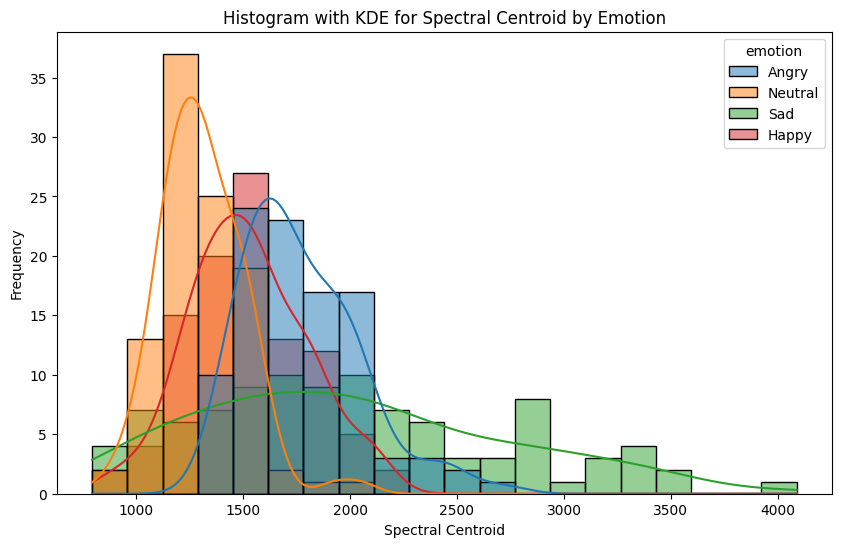

In [47]:
plot_histogram_with_kde(spectral_centroid_df, 'Spectral Centroid', 'Spectral Centroid')

### Strip plot for Spectral Centroid vs Emotion

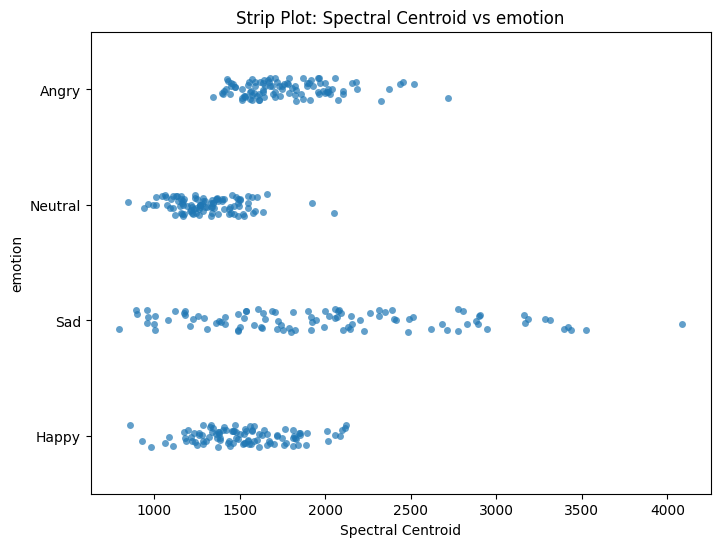

In [48]:
plot_feature_vs_categorical_target(spectral_centroid_df, 'Spectral Centroid', target_column="emotion")

### Scatterplot for Spectral Centroid

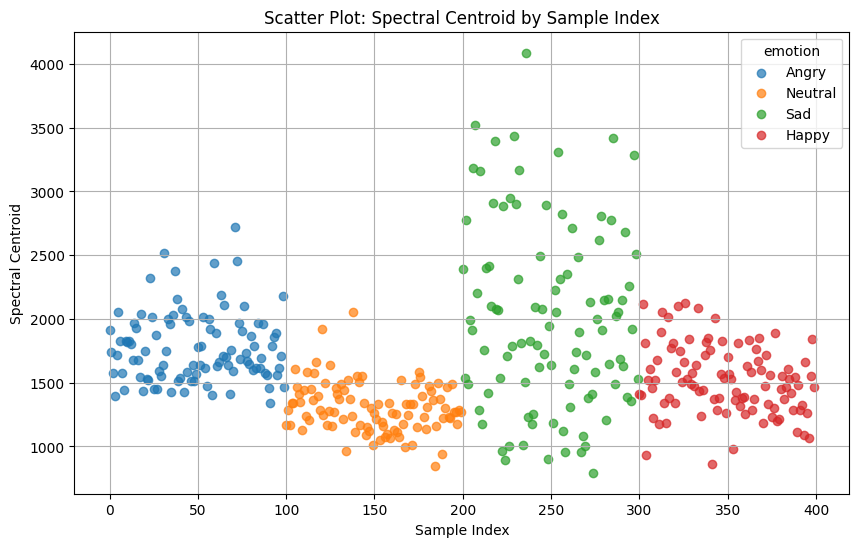

In [49]:
scatter_plot_feature_by_sample(spectral_centroid_df, 'Spectral Centroid')

### Box Plot of Spectral Centroid by Emotion

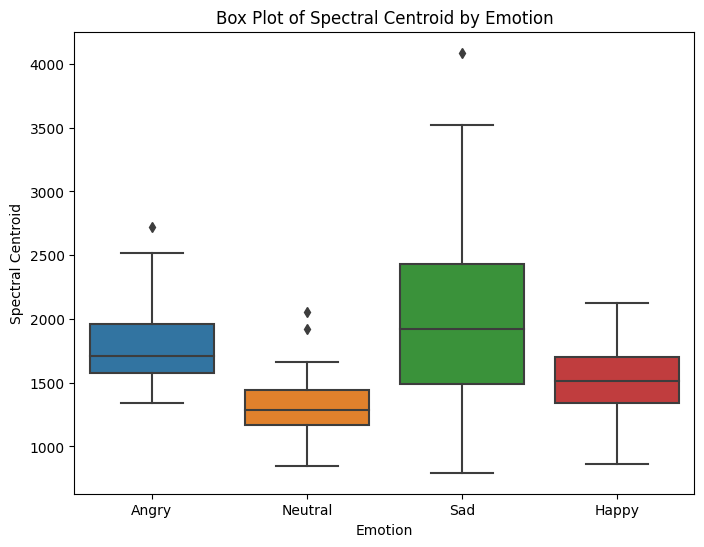

In [50]:
plot_boxplot(spectral_centroid_df, 'Spectral Centroid', 'Spectral Centroid')

## 7. Spectral Bandwidth

In [51]:
spectral_bandwidth_list = []
for _, row in metadata_df.iterrows():
    data, sample_rate = librosa.load(row["file"])
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).mean()
    spectral_bandwidth_list.append([spectral_bandwidth, row["emotion"]])

spectral_bandwidth_df = pd.DataFrame(spectral_bandwidth_list, columns=["Spectral Bandwidth", "emotion"])
spectral_bandwidth_df.head()


Spectral Bandwidth emotion
0         1844.523496   Angry
1         1850.987649   Angry
2         1768.868170   Angry
3         1630.905268   Angry
4         1958.669797   Angry

In [52]:
spectral_bandwidth_df.describe()

Spectral Bandwidth
count          400.000000
mean          1866.373413
std            310.074473
min           1014.160552
25%           1686.004497
50%           1823.943428
75%           2024.867975
max           2842.288932

### Histogram for Spectral Bandwidth by Emotion

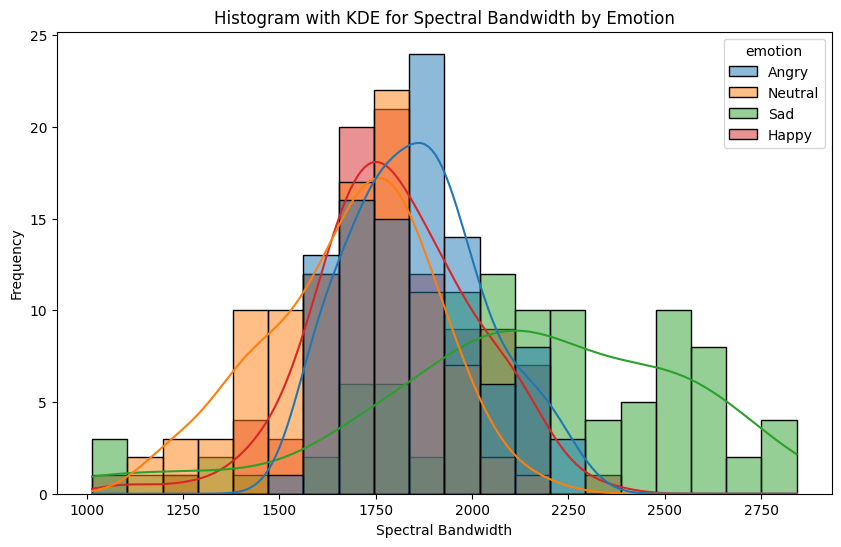

In [53]:
plot_histogram_with_kde(spectral_bandwidth_df, 'Spectral Bandwidth', 'Spectral Bandwidth')

### Strip plot for Spectral Bandwidth vs Emotion

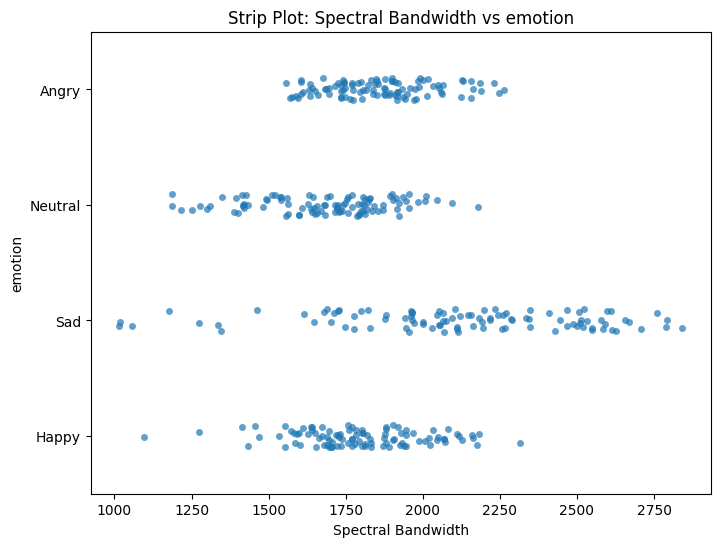

In [54]:
plot_feature_vs_categorical_target(spectral_bandwidth_df, 'Spectral Bandwidth', target_column="emotion")

### Scatterplot for Spectral Bandwidth

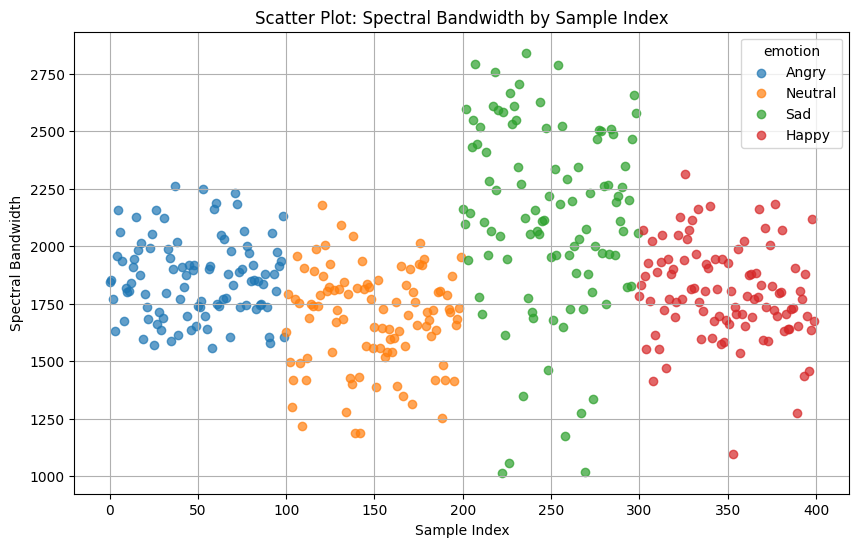

In [55]:
scatter_plot_feature_by_sample(spectral_bandwidth_df, 'Spectral Bandwidth')

### Box Plot of Spectral Bandwidth by Emotion

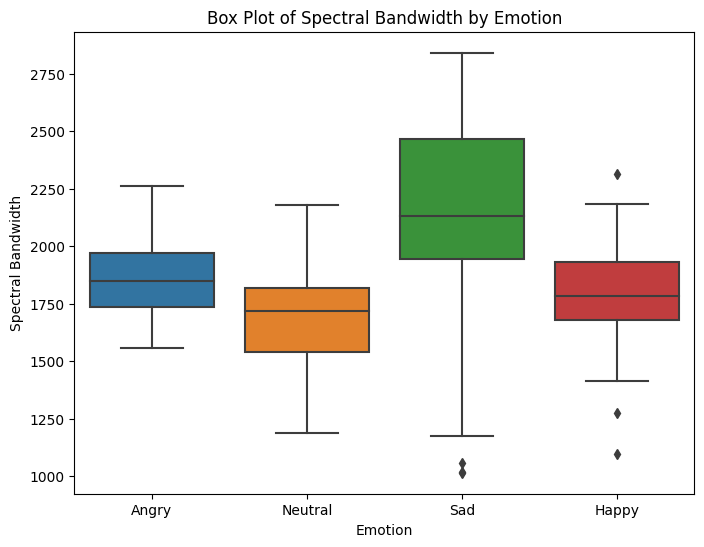

In [56]:
plot_boxplot(spectral_bandwidth_df, 'Spectral Bandwidth', 'Spectral Bandwidth')

# 5. Features Dataset

In [57]:
emotions_df = pd.concat(
    [zcr_df[["ZCR"]], 
     mfcc_df.iloc[:, :-1],  # Drop emotion temporarily
     chroma_df.iloc[:, :-1], 
     rms_df[["RMS"]],
     mel_df[["Mel"]],
     spectral_centroid_df[["Spectral Centroid"]],
     spectral_bandwidth_df[["Spectral Bandwidth"]]],
    axis=1
)

emotions_df["emotion"] = metadata_df["emotion"]


In [58]:
emotions_df.head()

ZCR      MFCC_0      MFCC_1     MFCC_2     MFCC_3     MFCC_4  \
0  0.091320 -188.470764  109.967346 -42.413364  33.335987 -30.330341   
1  0.070887 -248.053299  103.685173 -18.847075  38.517456 -19.335085   
2  0.061798 -256.788513  115.254929 -12.114532  27.983555 -28.089148   
3  0.057061 -238.685577  127.544350  -9.724557  22.484619 -18.023149   
4  0.049745 -176.139725  114.823135 -34.065102  11.556516   7.050622   

      MFCC_5     MFCC_6    MFCC_7     MFCC_8  ...  Chroma_7  Chroma_8  \
0   9.138726 -39.706383  7.189990 -11.838692  ...  0.438342  0.485886   
1   5.011625 -40.926052 -7.197815 -13.969601  ...  0.330277  0.331038   
2   7.765107 -30.097071 -2.629414 -21.728060  ...  0.286827  0.315547   
3  10.864928 -31.297428 -1.836660 -13.216015  ...  0.386586  0.531828   
4 -17.943701 -21.713697  8.152995 -15.158186  ...  0.471560  0.481194   

   Chroma_9  Chroma_10  Chroma_11       RMS       Mel  Spectral Centroid  \
0  0.492630   0.440898   0.522234  0.116387  4.487679        1912.396437   
1  0.406119   0.449119   0.581985  0.087585  2.635538        1738.408594   
2  0.441678   0.590957   0.773464  0.091757  2.837139        1575.015891   
3  0.692188   0.651474   0.490581  0.109497  4.187739        1396.520759   
4  0.438975   0.506700   0.510406  0.106876  2.462297        1715.942236   

   Spectral Bandwidth  emotion  
0         1844.523496    Angry  
1         1850.987649    Angry  
2         1768.868170    Angry  
3         1630.905268    Angry  
4         1958.669797    Angry  

[5 rows x 38 columns]

In [59]:
emotions_df['emotion'] =  metadata_df["emotion"]

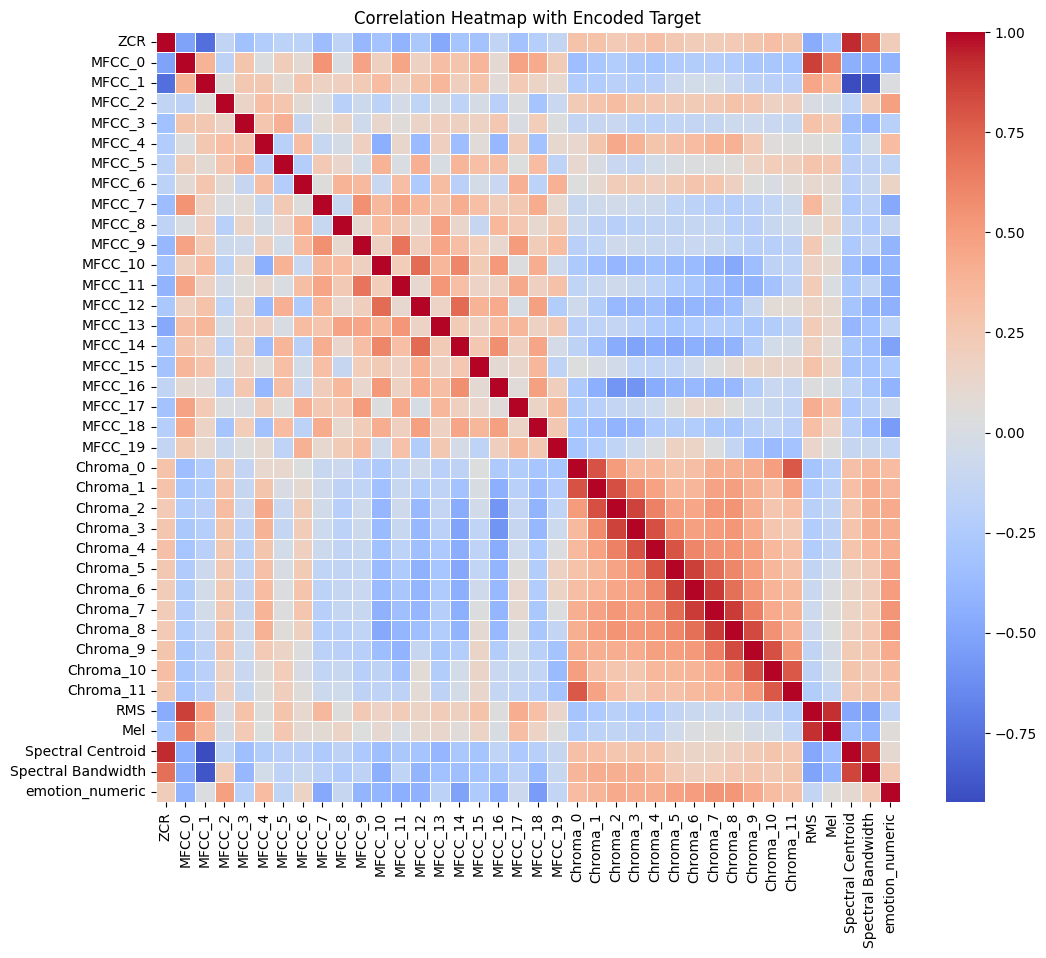

In [60]:
plot_correlation_heatmap(emotions_df, target_column="emotion", annot=False)

# 6. Data Augmentation

In [61]:
def augment_audio(file_path, augmentation_type):
    y, sr = librosa.load(file_path, sr=None)
    if augmentation_type == 'time_stretch':
        # Randomly stretch or compress time 
        rate = np.random.uniform(0.8, 1.2)
        y_aug = librosa.effects.time_stretch(y, rate=rate)
    
    elif augmentation_type == 'pitch_shift':
        # Randomly shift pitch 
        n_steps = np.random.uniform(-4, 4)
        y_aug = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    
    elif augmentation_type == 'noise':
        # Add random Gaussian noise
        noise_amp = np.random.uniform(0.001, 0.03)
        noise = np.random.normal(0, noise_amp, len(y))
        y_aug = y + noise
    
    else:
        raise ValueError("Invalid augmentation type")
    
    return y_aug, sr

In [62]:
example_file = metadata_df.iloc[205]['file']
example_data, example_sr = librosa.load(example_file, sr=None)

print("Original Audio:")
display(Audio(example_data, rate=example_sr))


print("\nTime-Stretched Audio:")
aug_y, sr = augment_audio(example_file, 'time_stretch')
display(Audio(aug_y, rate=sr))

print("\nPitch-Shifted Audio:")
aug_y, sr = augment_audio(example_file, 'pitch_shift')
display(Audio(aug_y, rate=sr))

print("\nNoisy Audio:")
aug_y, sr = augment_audio(example_file, 'noise')
display(Audio(aug_y, rate=sr))

Original Audio:



Time-Stretched Audio:



Pitch-Shifted Audio:



Noisy Audio:


In [63]:
def extract_features_from_augmented(augmented_data, sr, emotion):
    zcr = librosa.feature.zero_crossing_rate(y=augmented_data).mean()
    mfcc = librosa.feature.mfcc(y=augmented_data, sr=sr).mean(axis=1)
    stft = np.abs(librosa.stft(augmented_data))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr).mean(axis=1)
    rms = librosa.feature.rms(y=augmented_data).mean()
    mel = librosa.feature.melspectrogram(y=augmented_data, sr=sr).mean()
    spectral_centroid = librosa.feature.spectral_centroid(y=augmented_data, sr=sr).mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=augmented_data, sr=sr).mean()
    features = [zcr] + list(mfcc) + list(chroma) + [rms, mel, spectral_centroid, spectral_bandwidth]
    
    return features

In [64]:
def augment_and_extract_features(metadata_df):
   
    augmented_features = []
    augmentation_types = ['noise', 'time_stretch', 'pitch_shift']
    
    for _, row in metadata_df.iterrows():
        file_path = row['file']
        emotion = row['emotion']
        
        # Apply each augmentation type
        for aug_type in augmentation_types:
            y_aug, sr = augment_audio(file_path, aug_type)
            
            features = extract_features_from_augmented(y_aug, sr, emotion)
            features.append(emotion)
            augmented_features.append(features)
    
    column_names = (
        ['ZCR'] + 
        [f'MFCC_{i}' for i in range(20)] + 
        [f'Chroma_{i}' for i in range(12)] + 
        ['RMS', 'Mel', 'Spectral Centroid', 'Spectral Bandwidth', 'emotion']
    )
    
    # Create DataFrame
    augmented_features_df = pd.DataFrame(augmented_features, columns=column_names)
    
    return augmented_features_df

In [65]:
augmented_emotions_df = augment_and_extract_features(metadata_df)

final_emotions_df = pd.concat([emotions_df, augmented_emotions_df], ignore_index=True)

In [66]:
final_emotions_df.shape

(1600, 38)

# 7. Data Preparation

In [67]:
def prepare_data(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Reshape for 1D CNN/LSTM
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_encoded = to_categorical(y_encoded)
    
    return X_scaled, y_encoded, label_encoder

# 8. Training and Evaluation

In [68]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv1D(256, kernel_size=3, activation='relu'),
        Flatten(),
        Dropout(0.25),
        
        # Fully Connected Layers
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [69]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        # LSTM Layers
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        
        LSTM(64),
        Dropout(0.25),
        
        # Fully Connected Layers
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [70]:
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        # CNN Layers
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # LSTM Layers
        LSTM(64, return_sequences=True),
        LSTM(32),
        
        # Fully Connected Layers
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [71]:
def plot_training_history(name, history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

In [72]:
def train_and_evaluate_models(X, y):
    X_scaled, y_encoded, label_encoder = prepare_data(X, y)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42
    )
    
    models = {
        'CNN': create_cnn_model(X_scaled.shape[1:], y_encoded.shape[1]),
        'LSTM': create_lstm_model(X_scaled.shape[1:], y_encoded.shape[1]),
        'CNN-LSTM': create_cnn_lstm_model(X_scaled.shape[1:], y_encoded.shape[1])
    }

    for name, model in models.items():
        print(f"\n{name} Model Summary:")
        print(model.summary())
        print(f"\n{name} Model Training:")
        
        # Training the model and saving history
        history = model.fit(
            X_train, y_train, 
            epochs=50, 
            batch_size=32, 
            validation_split=0.2,
            verbose=1
        )
        
        # Evaluating the model on the test set
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        print(f"{name} Test Accuracy: {test_accuracy*100:.2f}%")
        print(f"{name} Test Loss: {test_loss:.4f}")
        
        # Confusion Matrix and Classification Report
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_test, axis=1)
        
        print(f"\n{name} Classification Report:")
        print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
        
        print(f"{name} Confusion Matrix:")
        cm = confusion_matrix(y_true, y_pred_classes)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # Plotting Training and Testing Loss & Accuracy
        plot_training_history(name, history)

    return models

In [73]:
X = final_emotions_df.drop('emotion', axis=1)
y = final_emotions_df['emotion']


CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 35, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,004 (1.10 MB)

 Trainable params: 288,004 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

None

CNN Model Training:
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3694 - loss: 1.2708 - val_accuracy: 0.6875 - val_loss: 0.8007
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6371 - loss: 0.8513 - val_accuracy: 0.7266 - val_loss: 0.6245
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7081 - loss: 0.7061 - val_accuracy: 0.7734 - val_loss: 0.5988
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7492 - loss: 0.6111 - val_accuracy: 0.7578 - val_loss: 0.6394
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7737 - loss: 0.6043 - val_accuracy: 0.8242 - val_loss: 0.4486
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7915 - loss: 0.5120 - val_accuracy: 0.8594 - val_loss: 0.4132
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8434 - loss: 0.4001 - val_accuracy: 0.8906 - val_loss: 0.3743
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8577 - loss: 0.3979 -

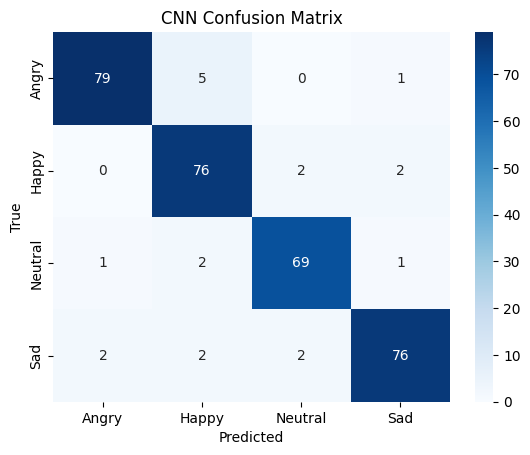

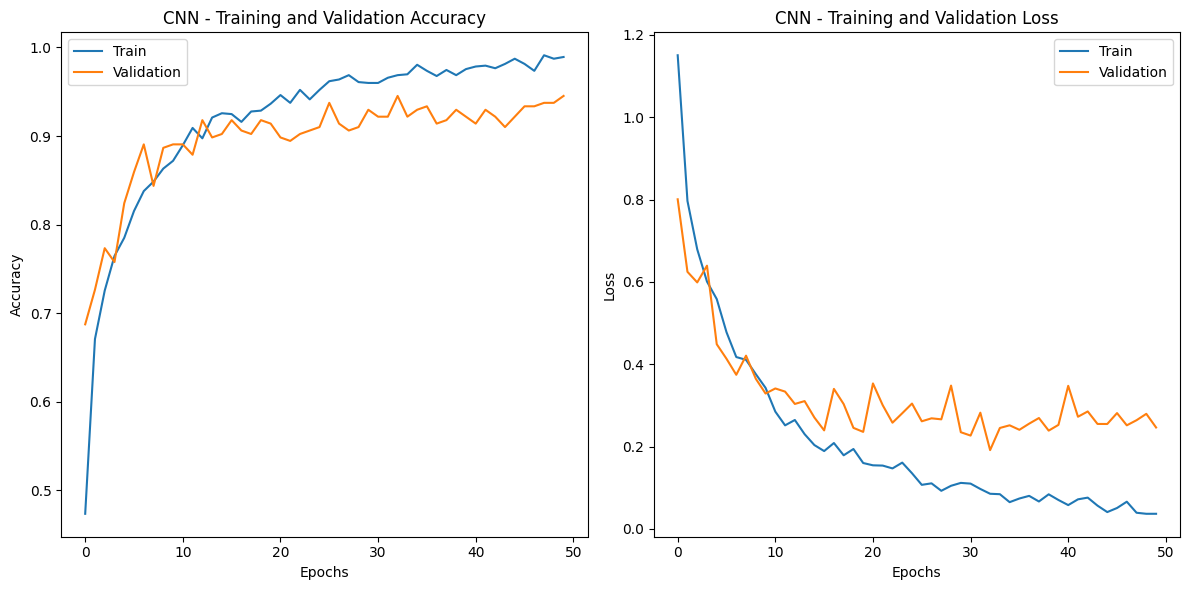


LSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 37, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,804 (487.52 KB)

 Trainable params: 124,804 (487.52 KB)

 Non-trainable params: 0 (0.00 B)

None

LSTM Model Training:
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.3305 - loss: 1.3287 - val_accuracy: 0.5938 - val_loss: 1.0244
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5881 - loss: 1.0105 - val_accuracy: 0.6797 - val_loss: 0.9165
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6246 - loss: 0.8947 - val_accuracy: 0.6719 - val_loss: 0.8385
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6622 - loss: 0.8441 - val_accuracy: 0.6836 - val_loss: 0.7182
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6745 - loss: 0.8004 - val_accuracy: 0.7227 - val_loss: 0.7214
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7087 - loss: 0.7613 - val_accuracy: 0.6914 - val_loss: 0.7330
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7068 - loss: 0.7235 - val_accuracy: 0.7266 - val_loss: 0.7466
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6979 - loss: 0.7420

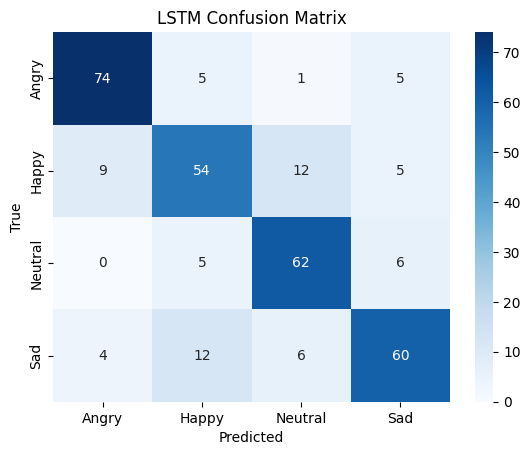

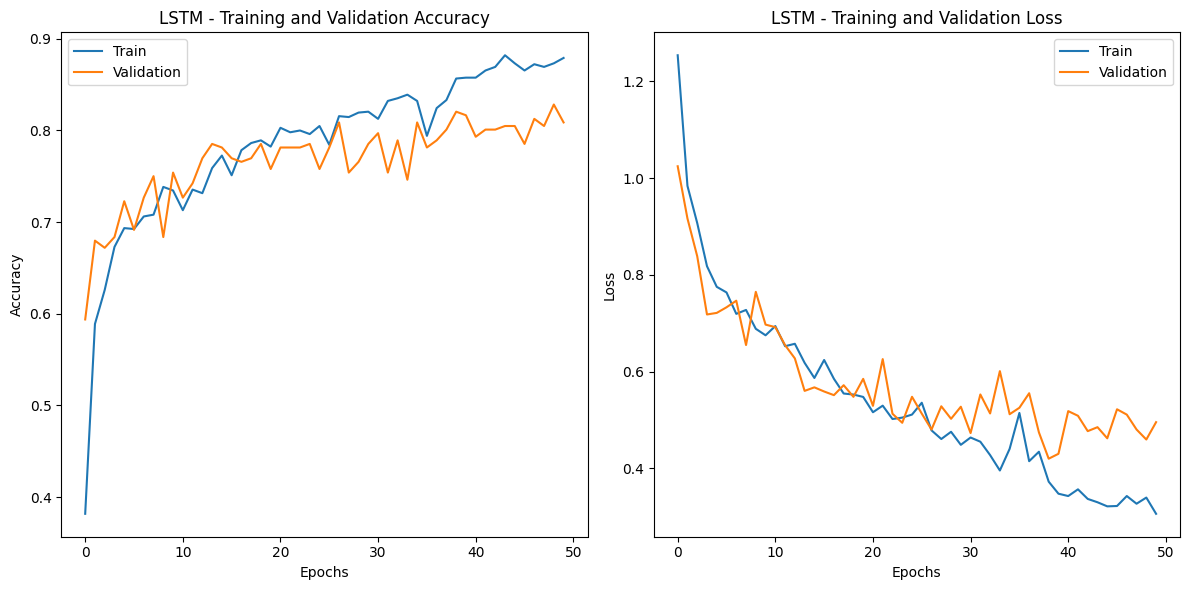


CNN-LSTM Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 35, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 7, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,524 (357.52 KB)

 Trainable params: 91,524 (357.52 KB)

 Non-trainable params: 0 (0.00 B)

None

CNN-LSTM Model Training:
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2953 - loss: 1.3588 - val_accuracy: 0.4766 - val_loss: 1.1432
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5092 - loss: 1.1052 - val_accuracy: 0.5703 - val_loss: 0.9276
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6195 - loss: 0.8768 - val_accuracy: 0.6953 - val_loss: 0.7922
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7127 - loss: 0.7618 - val_accuracy: 0.6680 - val_loss: 0.7693
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7536 - loss: 0.6452 - val_accuracy: 0.7344 - val_loss: 0.6392
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7547 - loss: 0.6312 - val_accuracy: 0.7500 - val_loss: 0.6553
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7198 - loss: 0.6818 - val_accuracy: 0.7656 - val_loss: 0.6010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8288 - loss: 0.

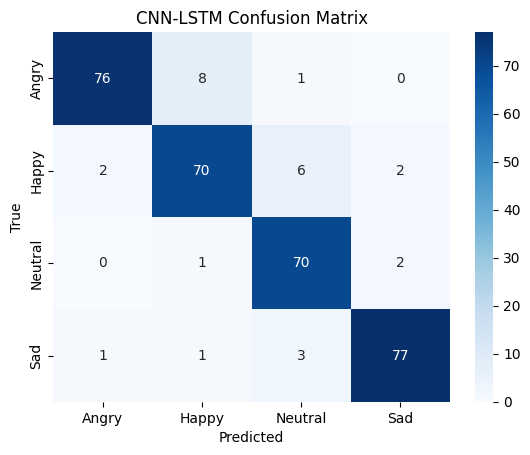

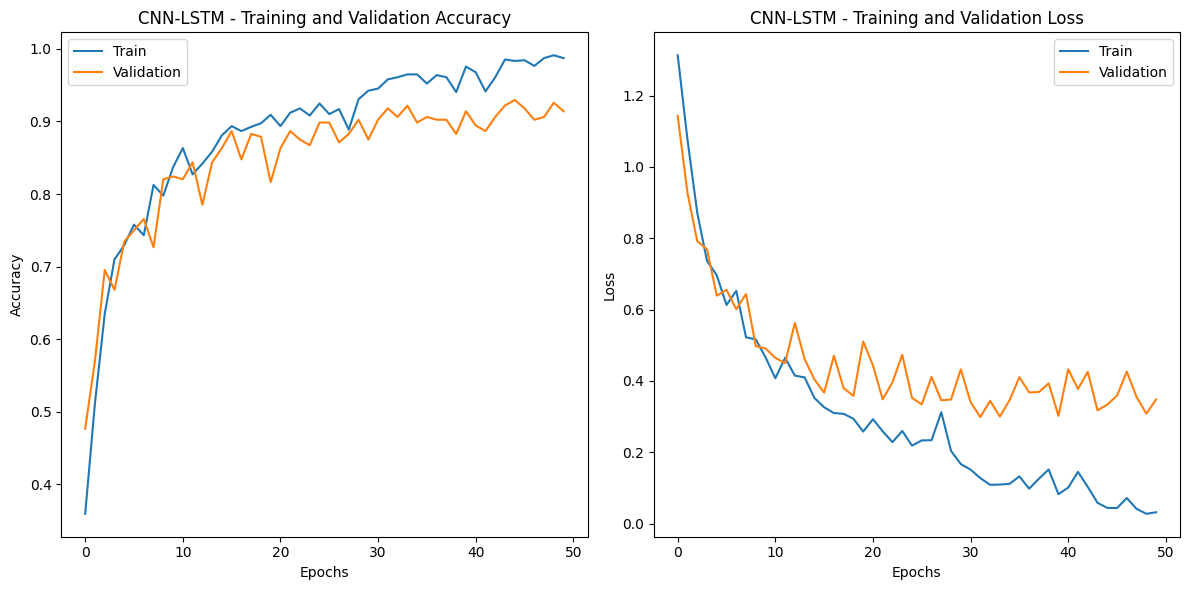

In [74]:
models = train_and_evaluate_models(X, y)